In [328]:
from IPython.display import clear_output
import shlex
import matplotlib.pyplot as plt
from brian2 import *
import ptitprince as pt
import seaborn as sns
import matplotlib.colors as mplcol
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from functions import *
import TVB.tvb_model_reference.src.nuu_tools_simulation_human as tools
from Tf_calc.theoretical_tools import *
import subprocess

from TVB.tvb_model_reference.simulation_file.parameter.parameter_M_Berlin_new import Parameter
parameters = Parameter()

import numpy as np
import ast  
from Tf_calc.cell_library import get_neuron_params_double_cell

from math import erf
from functions import *
from Tf_calc.theoretical_tools import convert_params
import json
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from matplotlib.backends.backend_pdf import PdfPages


In [60]:
def convert_values(input_dict):
    converted_dict = {}
    for key, value in input_dict.items():
        # Check for boolean values
        if value.lower() == 'true':
            converted_dict[key] = True
        elif value.lower() == 'false':
            converted_dict[key] = False
        # Check for integer values
        elif value.isdigit():
            converted_dict[key] = int(value)
        # Add more type checks if needed (e.g., for floats)
        else:
            converted_dict[key] = value  # Keep the value as is if no conversion is needed
    return converted_dict

class ParseKwargs(argparse.Action):
    def __call__(self, parser, namespace, values, option_string=None):
        setattr(namespace, self.dest, dict())
        for value in values:
            key, value = value.split('=')
            getattr(namespace, self.dest)[key] = value

In [61]:
start_scope()

# Single Neuron

In this implementation, we simulate a single neuron using the **AdEx model** (Adaptive Exponential Integrate-and-Fire).
The model equations are defined as follows:


$c_{m}  \frac{dv}{dt}  =  g_L(E_L-v)+ g_L\Delta e^{\frac{v-v_{thr}}{\Delta }} -W + I_{syn}$  

$\frac{dW}{dt}  =  -\frac{1}{\tau_w} (a(v-E_L) - W) + b \sum_{t_{sp}}\delta(t-t_{sp})$

These equations are used in the `eqs` variable of the Brian framework, which implements spiking neuron models.

You can select a different model and adjust the `eqs` and the relevant parameters of the model accordingly.

In [93]:
params = {
    'cell': 'RS', 
    'iext': 0.35,   
    'time': 500,  
    'kwargs': {    
        'use': True,
        'b': 85,
        'V_m': -65
    }
}


CELLS = params['cell']
neuron_params = get_neuron_params_double_cell(CELLS)  

kwargs = params['kwargs']

print("Used Params:", kwargs)

if kwargs.get('use', False):
    for key in kwargs.keys():
        if key in neuron_params.keys():
            neuron_params[key] = kwargs[key]
        elif key == 'use':
            continue
        else:
            raise Exception(f"Key '{key}' not in the valid keys \nValid keys: {neuron_params.keys()}")


locals().update(neuron_params)

cell parameters --NOT-- in SI units
Used Params: {'use': True, 'b': 85, 'V_m': -65}


Text(0, 0.5, 'vm')

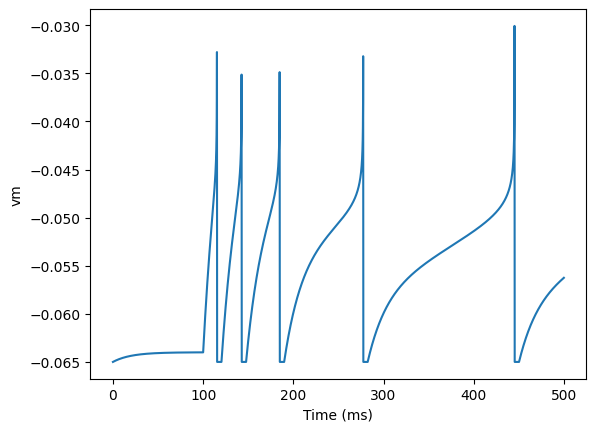

In [94]:

TotTime = params['time']
current_start = 100*ms  # 电流开始时间
current_duration = 400*ms  # 电流持续时间
current_end = current_start + current_duration  # 电流结束时间

# 创建时间相关的电流数组
current_times = np.arange(0, float(TotTime*ms), 0.1*ms)  # 时间点
current_values = np.zeros_like(current_times)  # 初始化为0

# 在指定时间段内设置电流值
mask = (current_times >= float(current_start)) & (current_times <= float(current_end))
current_values[mask] = params['iext']  # 设置电流值

# 创建 TimedArray
I_timed = TimedArray(current_values * nA, dt=0.1*ms)


C = Cm*pF
gL = Gl*nS
tauw = tau_w*ms
a =a*nS# 4*nS
Ee=E_e*mV
Ei=E_i*mV
I = Iext*nA


eqs = """
dvm/dt=(gL*(El-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)-GsynE*(vm-Ee)-GsynI*(vm-Ei)+I_timed(t)-w)/C : volt (unless refractory)
dw/dt=(a*(vm-El)-w)/tauw : amp
dGsynI/dt = -GsynI/TsynI : siemens
dGsynE/dt = -GsynE/TsynE : siemens
TsynI:second
TsynE:second
Vr:volt
b_e:amp
DeltaT:volt
Vcut:volt
VT:volt
El:volt
"""

G_exc = NeuronGroup(1, model=eqs, threshold='vm > Vcut',refractory=5*ms,
                     reset="vm = Vr; w += b_e", method='heun')
G_exc.vm = V_m*mV#EL
G_exc.w = a * (G_exc.vm - G_exc.El)
G_exc.Vr = V_r*mV 
G_exc.b_e=b*pA
G_exc.DeltaT=delta*mV
G_exc.VT=V_th*mV
# G_exc.Vcut=G_exc.VT + 5 * G_exc.DeltaT
G_exc.Vcut = V_cut*mV
G_exc.El=EL*mV
G_exc.TsynI =tau_e*ms
G_exc.TsynE =tau_i*ms



statemon_exc = StateMonitor(G_exc, 'vm', record=0)
spikemon_exc = SpikeMonitor(G_exc)

run(TotTime*ms)

plot(statemon_exc.t/ms, statemon_exc.vm[0])


xlabel('Time (ms)')
ylabel('vm')

# Network

In [213]:
neuron_params

{'V_m': -60,
 'V_r': -65,
 'Cm': 200,
 'Gl': 10,
 'tau_w': 500,
 'V_th': -50,
 'V_cut': -30,
 'a_e': 0,
 'b_e': 75,
 'delta_e': 2,
 'EL_e': -64,
 'a_i': 0,
 'b_i': 0,
 'delta_i': 0.5,
 'EL_i': -65,
 'tau_e': 5,
 'tau_i': 5,
 'E_e': 0,
 'E_i': -80,
 'Q_i': 5.0,
 'Q_e': 1.5,
 'p_con': 0.05,
 'gei': 0.2,
 'Ntot': 10000}

In [ ]:
params_all = {
    'awake': {
            'cells': 'FS-RS_10',  
            'iext': 0.4,       
            'input': 0,       
            'plat_dur': 0,     
            'time': 4000,      
            'save_path': None, 
            'save_mean': True, 
            'save_all': False, 
            'kwargs': {       
                'use': True,
                'b_e': 5
            }
        },
    'NREM':{
            'cells': 'FS-RS_10',  
            'iext': 0.4,       
            'input': 0,       
            'plat_dur': 0,     
            'time': 4000,      
            'save_path': None, 
            'save_mean': True, 
            'save_all': False, 
            'kwargs': {       
                'use': True,
                'b_e': 75
            }
        }
}

In [350]:
test_params = {
    'awake': {
            'cells': 'FS-RS_10',  
            'iext': 0.4,       
            'input': 4,       
            'plat_dur': 30,     
            'time': 4000,      
            'save_path': None, 
            'save_mean': True, 
            'save_all': False, 
            'kwargs': {       
                'use': True,
                'b_e': 5
            }
        },
    'NREM':{
            'cells': 'FS-RS_10',  
            'iext': 0.4,       
            'input': 4,       
            'plat_dur': 30,     
            'time': 4000,      
            'save_path': None, 
            'save_mean': True, 
            'save_all': False, 
            'kwargs': {       
                'use': True,
                'b_e': 75
            }
        },
    'test_1_cm_100':{
        'cells': 'FS-RS_10',  
        'iext': 0.4,       
        'input': 4,       
        'plat_dur': 30,     
        'time': 4000,      
        'save_path': None, 
        'save_mean': True, 
        'save_all': False, 
        'kwargs': {       
            'use': True,
            'b_e': 5,
            'Cm': 100
        }
    },
    'test_2_cm_50':{
        'cells': 'FS-RS_10',  
        'iext': 0.4,       
        'input': 4,       
        'plat_dur': 30,     
        'time': 4000,      
        'save_path': None, 
        'save_mean': True, 
        'save_all': False, 
        'kwargs': {       
            'use': True,
            'b_e': 5,
            'Cm': 50
        }
    },
    'test_3_Vth_-60':{
        'cells': 'FS-RS_10',  
        'iext': 0.4,       
        'input': 4,       
        'plat_dur': 30,     
        'time': 4000,      
        'save_path': None, 
        'save_mean': True, 
        'save_all': False, 
        'kwargs': {       
            'use': True,
            'b_e': 5,
            'V_th': -60
        }
    },
    'test_4_tauw_300':{
        'cells': 'FS-RS_10',  
        'iext': 0.4,       
        'input': 4,       
        'plat_dur': 30,     
        'time': 4000,      
        'save_path': None, 
        'save_mean': True, 
        'save_all': False, 
        'kwargs': {       
            'use': True,
            'b_e': 5,
            'tau_w': 300
        }
    },
    'test_5_tauw_500':{
        'cells': 'FS-RS_10',  
        'iext': 0.4,       
        'input': 4,       
        'plat_dur': 30,     
        'time': 4000,      
        'save_path': None, 
        'save_mean': True, 
        'save_all': False, 
        'kwargs': {       
            'use': True,
            'b_e': 5,
            'tau_w': 500
        }
    },
    'test_6_tauw_1000':{
        'cells': 'FS-RS_10',  
        'iext': 0.4,       
        'input': 4,       
        'plat_dur': 30,     
        'time': 4000,      
        'save_path': None, 
        'save_mean': True, 
        'save_all': False, 
        'kwargs': {       
            'use': True,
            'b_e': 5,
            'tau_w': 1000
        }
    },
    'test_7_be_3':{
        'cells': 'FS-RS_10',  
        'iext': 0.4,       
        'input': 4,       
        'plat_dur': 30,     
        'time': 4000,      
        'save_path': None, 
        'save_mean': True, 
        'save_all': False, 
        'kwargs': {       
            'use': True,
            'b_e': 3,
        }
    },
    'test_input':{
        'cells': 'FS-RS_10',  
        'iext': 0.4,       
        'input': 4,       
        'plat_dur': 30,     
        'time': 4000,      
        'save_path': None, 
        'save_mean': True, 
        'save_all': False, 
        'kwargs': {       
            'use': True,
            'b_e': 20,
            'Cm': 50
        }
    }
}

In [351]:
for test in test_params.keys():
#for test in ['test_input']:

    with PdfPages(f"/media/ubuntu/sda/Molecular_elec/figure/seizure_test_{test}.pdf") as pdf:
        start_scope()

        params = test_params[test]

        #params = params_all['awake']
        CELLS = params['cells']

        neuron_params = get_neuron_params_double_cell(CELLS)

        kwargs = params['kwargs']

        if kwargs.get('use', False): # only if use=True
            for key in kwargs.keys():
                if key in neuron_params.keys():
                    neuron_params[key] = kwargs[key]
                elif key == 'use':
                    continue
                else:
                    raise Exception(f"Key '{key}' not in the valid keys \nValid keys: {neuron_params.keys()}")

        locals().update(neuron_params)

        save_path = params['save_path']
        save_mean = params['save_mean']
        save_all = params['save_all']
        TotTime = params['time']
        Iext = params['iext']
        AmpStim = params['input']
        plat_dur = params['plat_dur']

        TotTime = params['time']
        Iext = params['iext']

        # Calculate the number of neurons in each population
        N1 = int(gei*Ntot)
        N2 = int((1-gei)*Ntot)

        DT=0.1 # time step

        #Create the kick
        AmpStim = params['input'] #0
        time_peek = 2000
        TauP = 20 #20

        if not params['plat_dur']:
            plat = TotTime - time_peek - TauP #100
        else:
            plat = params['plat_dur']
        t2 = np.arange(0, TotTime, DT)
        test_input = []

        for ji in t2:
            # 基础背景电流 + 刺激输入
            base_input = Iext  # 正常背景电流
            stimulus = input_rate(ji, time_peek, TauP, 1, AmpStim, plat)
            test_input.append(base_input + stimulus)
        Input_Stim = TimedArray(test_input * Hz, dt=DT * ms)

        duration = TotTime*ms

        # Define neuron parameters
        C = Cm*pF
        gL = Gl*nS
        tauw = tau_w*ms

        I = 0.*nA
        Ee=E_e*mV
        Ei=E_i*mV


        seed(9) #9,11,25

        sim_name = f'_b_{b_e}_tau_e_{tau_e}_tau_i_{tau_i}_eli_{int(EL_i)}_ele_{int(EL_e)}_iext_{Iext}'


        print('b_e= ', b_e)
        eqs = """
        dvm/dt=(gL*(EL-vm)+gL*DeltaT*exp((vm-VT)/DeltaT)-GsynE*(vm-Ee)-GsynI*(vm-Ei)+I-w)/C : volt (unless refractory)
        dw/dt=(a*(vm-EL)-w)/tauw : amp
        dGsynI/dt = -GsynI/TsynI : siemens
        dGsynE/dt = -GsynE/TsynE : siemens
        TsynI:second
        TsynE:second
        Vr:volt
        b:amp
        a:siemens
        DeltaT:volt
        Vcut:volt
        VT:volt
        EL:volt
        """

        # Population 1 - Fast Spiking

        G_inh = NeuronGroup(N1, model=eqs, threshold='vm > Vcut',refractory=5*ms,
                            reset="vm = Vr; w += b", method='heun')
        G_inh.vm = V_m * mV 
        G_inh.a = a_i * nS 
        G_inh.w = G_inh.a * (G_inh.vm - G_inh.EL)
        G_inh.Vr = V_r * mV  
        G_inh.TsynI = tau_i * ms  
        G_inh.TsynE = tau_e * ms  
        G_inh.b = b_i * pA
        G_inh.DeltaT = delta_i * mV
        G_inh.VT = V_th * mV
        G_inh.Vcut = V_cut * mV
        G_inh.EL = EL_i * mV

        # Population 2 - Regular Spiking

        G_exc = NeuronGroup(N2, model=eqs, threshold='vm > Vcut',refractory=5*ms,
                            reset="vm = Vr; w += b", method='heun')
        G_exc.vm = V_m*mV
        G_exc.a = a_e * nS 
        G_exc.w = G_exc.a * (G_exc.vm - G_exc.EL)
        G_exc.Vr = V_r*mV
        G_exc.TsynI =tau_i*ms
        G_exc.TsynE =tau_e*ms
        G_exc.b=b_e*pA
        G_exc.DeltaT=delta_e*mV
        G_exc.VT=V_th*mV
        G_exc.Vcut = V_cut * mV
        G_exc.EL=EL_e*mV

        # external drive--------------------------------------------------------------------------
        if AmpStim > 0:
            print("Input =", AmpStim, 'plat=', plat)
            P_ed=PoissonGroup(N2, rates='Input_Stim(t)')
        else:
            P_ed=PoissonGroup(N2, rates=Iext*Hz)

        # Network-----------------------------------------------------------------------------

        # connections-----------------------------------------------------------------------------
        #seed(0)
        Qi=Q_i*nS
        Qe=Q_e*nS

        prbC=p_con #0.05

        S_12 = Synapses(G_inh, G_exc, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV')
        S_12.connect('i!=j', p=prbC)

        S_11 = Synapses(G_inh, G_inh, on_pre='GsynI_post+=Qi')
        S_11.connect('i!=j',p=prbC)

        S_21 = Synapses(G_exc, G_inh, on_pre='GsynE_post+=Qe')
        S_21.connect('i!=j',p=prbC)

        S_22 = Synapses(G_exc, G_exc, on_pre='GsynE_post+=Qe')
        S_22.connect('i!=j', p=prbC)

        S_ed_in = Synapses(P_ed, G_inh, on_pre='GsynE_post+=Qe')
        S_ed_in.connect(p=prbC)

        S_ed_ex = Synapses(P_ed, G_exc, on_pre='GsynE_post+=Qe')
        S_ed_ex.connect(p=prbC)

        PgroupE = NeuronGroup(1, 'P:amp', method='heun')

        PE=Synapses(G_exc, PgroupE, 'P_post = w_pre : amp (summed)')
        PE.connect(p=1)
        P2mon = StateMonitor(PgroupE, 'P', record=0)

        # Recording tools -------------------------------------------------------------------------------
        rec1=2000
        rec2=8000

        M1G_inh = SpikeMonitor(G_inh)
        FRG_inh = PopulationRateMonitor(G_inh)
        M1G_exc = SpikeMonitor(G_exc)
        FRG_exc = PopulationRateMonitor(G_exc)
        exc_mon = StateMonitor(G_exc, ['vm', 'GsynE', 'GsynI'], record=True)
        inh_mon = StateMonitor(G_inh, ['vm', 'GsynE', 'GsynI'], record=True)
        # Run simulation -------------------------------------------------------------------------------

        print('--##Start simulation##--')
        run(duration)
        print('--##End simulation##--')

        RasG_inh = np.array([M1G_inh.t / ms, [i + N2 for i in M1G_inh.i]])
        RasG_exc = np.array([M1G_exc.t / ms, M1G_exc.i])
        if AmpStim > 0:
            time_array = np.arange(int(TotTime / DT)) * DT
            input_bin = bin_array(np.array(test_input), 5, time_array)
        else:
            input_bin = np.full(1, np.nan)
        TimBinned, popRateG_exc, popRateG_inh, Pu = prepare_FR(TotTime, DT, FRG_exc, FRG_inh, P2mon, BIN=5)
        if save_path:
            try:
                os.listdir(save_path)
            except:
                os.makedirs(save_path)
            
            if save_mean:
                print("Saving the mean")
                # print("Exc=", np.mean(popRateG_exc[int(len(popRateG_exc)/2):]), "Inh=",np.mean(popRateG_inh[int(len(popRateG_inh)/2):]))
                np.save(save_path + f'{CELLS}_mean_exc_amp_{AmpStim}.npy', np.array([np.mean(popRateG_exc[int(len(popRateG_exc)/2):]),AmpStim, neuron_params], dtype=object))
                np.save(save_path + f'{CELLS}_mean_inh_amp_{AmpStim}.npy', np.array([np.mean(popRateG_inh[int(len(popRateG_inh)/2):]), AmpStim, neuron_params], dtype=object))
            if save_all:
                print("Saving the whole simulation")
                np.save(save_path + f'{CELLS}_inh_amp_{AmpStim}.npy', np.array([popRateG_inh, AmpStim, neuron_params], dtype=object))
                np.save(save_path + f'{CELLS}_exc_amp_{AmpStim}.npy', np.array([popRateG_exc,AmpStim, neuron_params], dtype=object))

        # # ----- Raster plot + mean adaptation ------

        # fig, axes = plt.subplots(2, 1, figsize=(5, 8))

        # plot_raster_meanFR(RasG_inh, RasG_exc, TimBinned, popRateG_inh, popRateG_exc, Pu, axes, sim_name, input_bin)


        # print(f" done")
        # pdf.savefig(fig)
        # plt.close()

        def calculate_epileptic_eeg(exc_mon, inh_mon, Ee, Ei):
            exc_I_exc = exc_mon.GsynE * (exc_mon.vm - Ee)
            exc_I_inh = exc_mon.GsynI * (exc_mon.vm - Ei)
            
            inh_I_exc = inh_mon.GsynE * (inh_mon.vm - Ee)
            inh_I_inh = inh_mon.GsynI * (inh_mon.vm - Ei)
            
            eeg_signal = (
                4.0 * np.mean(exc_I_exc - exc_I_inh, axis=0) + 
                1.0 * np.mean(inh_I_exc - inh_I_inh, axis=0)
            )
            
            return eeg_signal

        eeg_signal = calculate_epileptic_eeg(exc_mon, inh_mon, Ee, Ei)

        from scipy import signal
        fs = 1000/DT 
        nyquist = fs/2

        bands = {
            'delta': (1, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 80),
            'high_gamma': (80, 150),
            'seizure': (3, 70)
        }


        from scipy import signal 

        eeg_signal = np.array(eeg_signal).reshape(len(eeg_signal), 1)
        recording = se.NumpyRecording(eeg_signal, sampling_frequency=fs)
        recording_delta = spre.bandpass_filter(recording, freq_min=bands['delta'][0], freq_max=bands['delta'][1])
        recording_gamma = spre.bandpass_filter(recording, freq_min=bands['high_gamma'][0], freq_max=bands['high_gamma'][1])
        recording_seizure = spre.bandpass_filter(recording, freq_min=bands['seizure'][0], freq_max=bands['seizure'][1])

        frequencies, psd = signal.welch(eeg_signal.flatten(), fs, nperseg=100000)

        plt.figure(figsize=(15, 12))  

        plt.subplot(4, 1, 1)
        plt.plot(exc_mon.t/ms, recording.get_traces())
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude')
        plt.title('Simulated Epileptic EEG-like Signal')
        plt.xlim(500, 4000)
        plt.grid(True)

        plt.subplot(4, 1, 2)
        plt.plot(exc_mon.t/ms, recording_gamma.get_traces())
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude')
        plt.title('High Gamma Oscillations (80-150 Hz) - Typical in Epilepsy')
        plt.xlim(500, 4000)
        plt.ylim(-3 * 1e-9, 3 * 1e-9)
        plt.grid(True)

        plt.subplot(4, 1, 3)
        plt.plot(exc_mon.t/ms, recording_delta.get_traces())
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude')
        plt.title('Delta Oscillations (0.5-4 Hz) - Typical in Epilepsy')
        plt.xlim(500, 4000)
        plt.grid(True)

        plt.subplot(4, 1, 4)
        plt.plot(exc_mon.t/ms, recording_seizure.get_traces())
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude')
        plt.title('Seizure Oscillations (3-70 Hz) - Typical in Epilepsy')
        plt.xlim(500, 4000)
        plt.ylim(-1e-8, 1e-8)

        plt.grid(True)
        #plt.xlim(0, 20)  

        plt.tight_layout()
        pdf.savefig()
        plt.close()


cell parameters --NOT-- in SI units
b_e=  5
Input = 4 plat= 30
--##Start simulation##--
--##End simulation##--


WARNING    /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '
 [py.warnings]


2025-09-06 13:01:07,751 - WARNING - py.warnings - /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '

cell parameters --NOT-- in SI units
b_e=  75
Input = 4 plat= 30
--##Start simulation##--
--##End simulation##--


WARNING    /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '
 [py.warnings]


2025-09-06 13:01:34,309 - WARNING - py.warnings - /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '

cell parameters --NOT-- in SI units
b_e=  5
Input = 4 plat= 30
--##Start simulation##--
--##End simulation##--


WARNING    /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '
 [py.warnings]


2025-09-06 13:02:07,495 - WARNING - py.warnings - /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '

cell parameters --NOT-- in SI units
b_e=  5
Input = 4 plat= 30
--##Start simulation##--
--##End simulation##--


WARNING    /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '
 [py.warnings]


2025-09-06 13:02:42,589 - WARNING - py.warnings - /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '

cell parameters --NOT-- in SI units
b_e=  5
Input = 4 plat= 30
--##Start simulation##--
--##End simulation##--


WARNING    /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '
 [py.warnings]


2025-09-06 13:03:18,262 - WARNING - py.warnings - /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '

cell parameters --NOT-- in SI units
b_e=  5
Input = 4 plat= 30
--##Start simulation##--
--##End simulation##--


WARNING    /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '
 [py.warnings]


2025-09-06 13:03:49,890 - WARNING - py.warnings - /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '

cell parameters --NOT-- in SI units
b_e=  5
Input = 4 plat= 30
--##Start simulation##--
--##End simulation##--


WARNING    /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '
 [py.warnings]


2025-09-06 13:04:20,879 - WARNING - py.warnings - /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '

cell parameters --NOT-- in SI units
b_e=  5
Input = 4 plat= 30
--##Start simulation##--
--##End simulation##--


WARNING    /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '
 [py.warnings]


2025-09-06 13:04:51,042 - WARNING - py.warnings - /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '

cell parameters --NOT-- in SI units
b_e=  3
Input = 4 plat= 30
--##Start simulation##--
--##End simulation##--


WARNING    /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '
 [py.warnings]


2025-09-06 13:05:22,762 - WARNING - py.warnings - /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '

cell parameters --NOT-- in SI units
b_e=  20
Input = 4 plat= 30
--##Start simulation##--
--##End simulation##--


WARNING    /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '
 [py.warnings]


2025-09-06 13:05:54,254 - WARNING - py.warnings - /home/ubuntu/.conda/envs/molecular_elec/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 40000, using nperseg = 40000
  warnings.warn('nperseg = {0:d} is greater than input length '



b_e=  1
--##Start simulation##--
--##End simulation##--


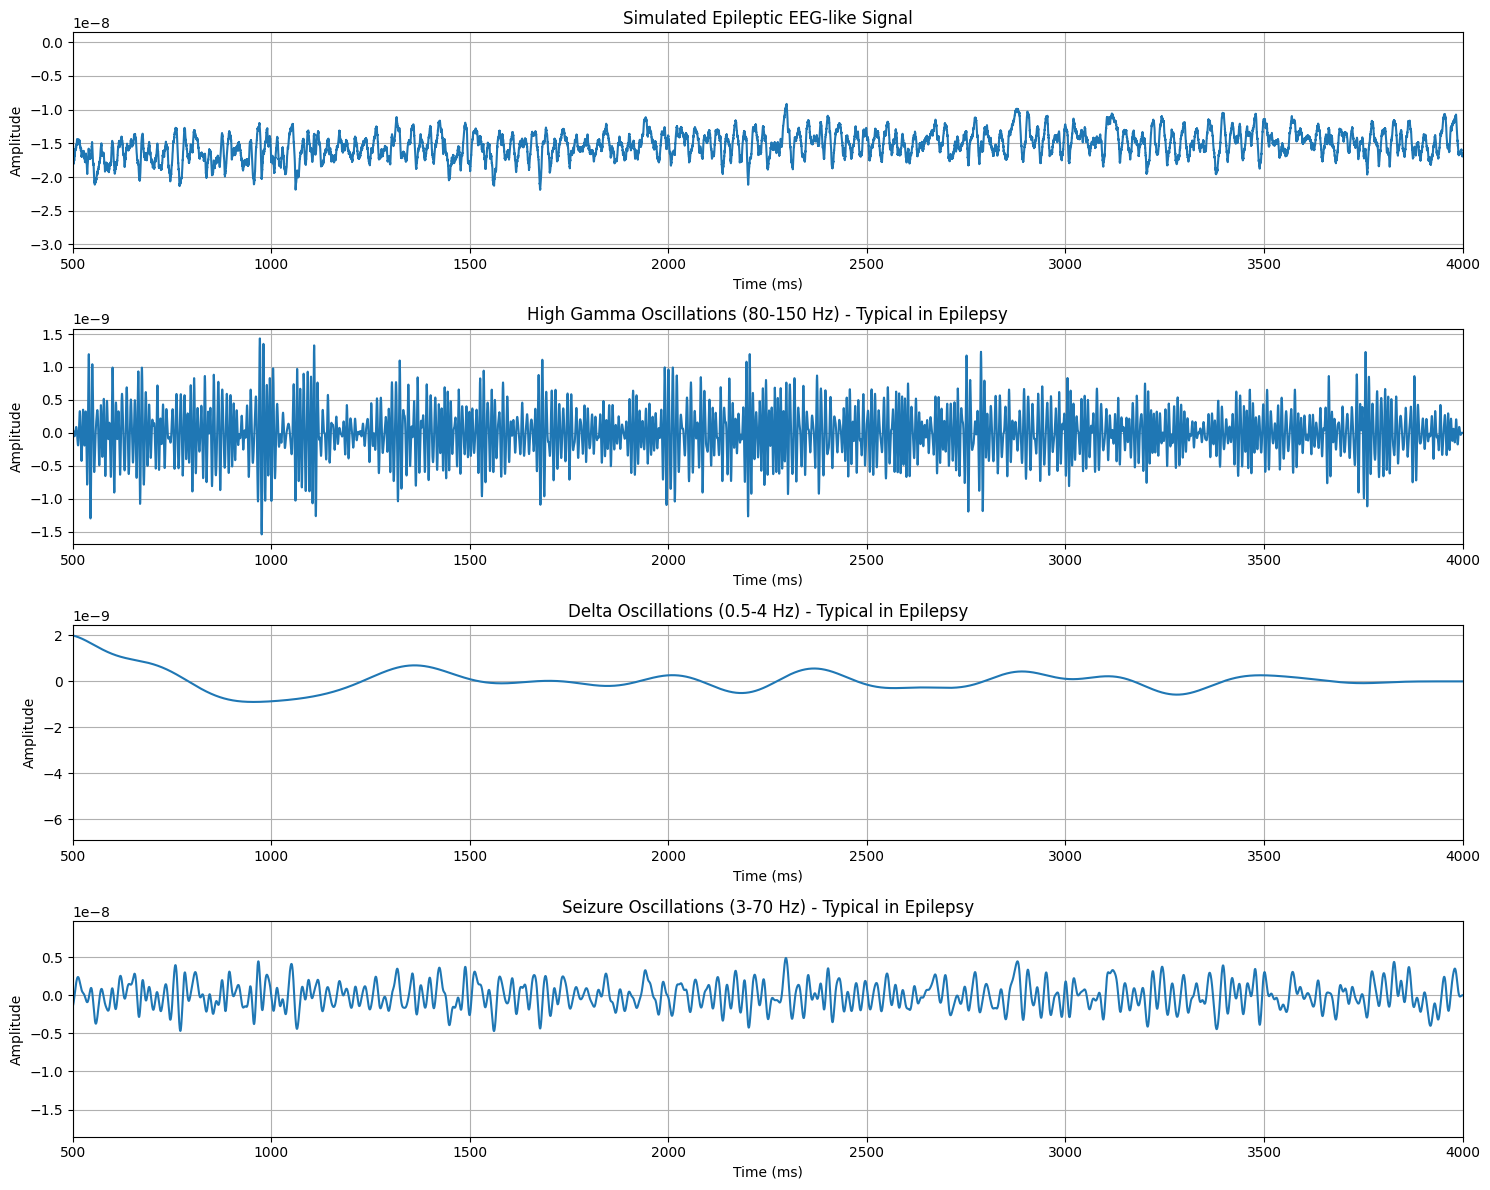

# Mean Field

In [49]:

def TF(P, fexc, finh, adapt, El):
    # Transfer Function 

    fe = fexc*(1.-gei)*pconnec*Ntot
    fi = finh*gei*pconnec*Ntot
    
    muGi = Qi*Ti*fi
    muGe = Qe*Te*fe
    muG = Gl+muGe+muGi
    muV = (muGe*Ee+muGi*Ei+Gl*El-adapt)/muG
    
    Tm = Cm/muG
    
    Ue =  Qe/muG*(Ee-muV)
    Ui = Qi/muG*(Ei-muV)
    sV = np.sqrt(fe*(Ue*Te)*(Ue*Te)/2./(Te+Tm)+fi*(Ui*Ti)*(Ui*Ti)/2./(Ti+Tm))
    
    fe = fe+1e-9
    fi = fi+1e-9
    Tv = ( fe*(Ue*Te)*(Ue*Te) + fi*(Qi*Ui)*(Qi*Ui)) /( fe*(Ue*Te)*(Ue*Te)/(Te+Tm) + fi*(Qi*Ui)*(Qi*Ui)/(Ti+Tm) )
    TvN = Tv*Gl/Cm
    
    muV0 = -60e-3
    DmuV0 = 10e-3
    sV0 = 4e-3
    DsV0 = 6e-3
    TvN0 = 0.5
    DTvN0 = 1.

    # Effective threshold
    
    vthr = P[0]+P[1]*(muV-muV0)/DmuV0+P[2]*(sV-sV0)/DsV0+P[3]*(TvN-TvN0)/DTvN0+P[4]*((muV-muV0)/DmuV0)*((muV-muV0)/DmuV0)+P[5]*((sV-sV0)/DsV0)*((sV-sV0)/DsV0)+P[6]*((TvN-TvN0)/DTvN0)*((TvN-TvN0)/DTvN0)+P[7]*(muV-muV0)/DmuV0*(sV-sV0)/DsV0+P[8]*(muV-muV0)/DmuV0*(TvN-TvN0)/DTvN0+P[9]*(sV-sV0)/DsV0*(TvN-TvN0)/DTvN0

    frout = .5/TvN*Gl/Cm*(1-erf((vthr-muV)/np.sqrt(2)/sV))
    
    return frout


def OU(tfin):
    # Ornstein-Ulhenbeck process
    
    theta = 1/(5*1.e-3 )  # Mean reversion rate
    mu = 0     # Mean of the process
    sigma = 1   # Volatility or standard deviation
    dt = 0.1*1.e-3    # Time increment
    T = tfin        # Total time period

    # Initialize the variables
    t = np.arange(0, T, dt)         # Time vector
    n = len(t)                      # Number of time steps
    x = np.zeros(n)                 # Array to store the process values
    x[0] = 0  # Initial value

    # Generate the process using the Euler-Maruyama method
    for i in range(1, n):
        dx = theta * (mu - x[i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        x[i] = x[i-1] + dx
    return x

config = {
    'cells': 'FS-RS',  # 细胞类型
    'iext': 0.315,       # 外部输入率
    'input': 0,        # 稳定输入幅度
    'plat_dur': 0,     # 平台持续时间
    'time': 10,        # 模拟时间
    'T': 20.0,         # 时间常数
    'file_fs': './Tf_calc/data/FS-cell_CONFIG1_fit.npy',  # FS细胞拟合文件
    'file_rs': './Tf_calc/data/RS-cell0_CONFIG1_fit.npy',  # RS细胞拟合文件
    'kwargs': {        # 参数字典
        'use': True,   # 默认不使用额外参数
        'b_e': 10
    }
}



kwargs_input = config['kwargs']
kwargs = convert_values(kwargs_input)

CELLS = config['cells']
params = get_neuron_params_double_cell(CELLS)

if kwargs.get('use', False):  # only if use=True
    for key in kwargs.keys():
        if key in params.keys():
            params[key] = kwargs[key]
        elif key == 'use':
            continue
        else:
            raise Exception(f"Key '{key}' not in the valid keys \nValid keys: {params.keys()}")

params = convert_params(params)
locals().update(params)



cell parameters --NOT-- in SI units
cell parameters in SI units


starting
done


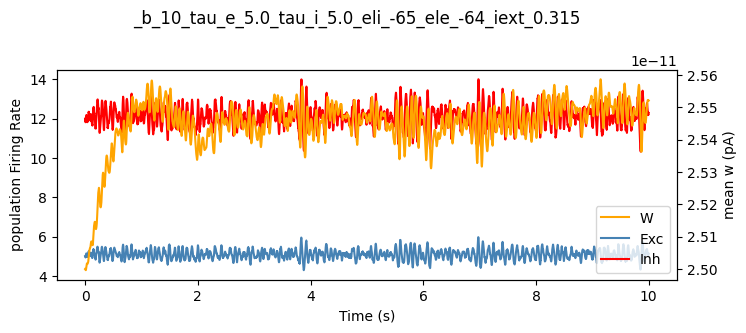

In [50]:
p = params

Iext = config['iext']
TotTime = config['time']

Gl = p['Gl']  # leak conductance
Cm = p['Cm']  # capacitance

Qe = p['Q_e']  # excitatory quantal conductance
Qi = p['Q_i']  # inhibitory quantal conductance

Ee = p['E_e']  # excitatory reversal potential
Ei = p['E_i']  # inhibitory reversal

twRS = p['tau_w']  # adaptation time constant 

# Network parameters
pconnec = p['p_con']  # probability of connection
gei = p['gei']  # percentage of inhibitory cells
Ntot = p['Ntot']  # total number of cells

# Fitting coefficients
PRS = np.load(config['file_rs'])
PFS = np.load(config['file_fs'])

# Time
tfinal = TotTime
dt = 0.0001
t = np.linspace(0, tfinal, int(tfinal/dt))

# Additive Noise
v_drive = Iext
sigma = 3.5
sigma = 1
os_noise = sigma*OU(tfinal) + v_drive

# Create the kick
AmpStim = config['input']  # 0
time_peek = 200.
TauP = 20  # 20

plat_dur = config['plat_dur']
if not plat_dur:
    plat = TotTime*1000 - time_peek - TauP  # 100
else:
    plat = plat_dur

test_input = []
t2 = np.arange(0, TotTime*1e3, 0.1)
for ji in t2:
    test_input.append(0. + input_rate(ji, time_peek, TauP, 1, AmpStim, plat))

# To adjust
bRS = p['b_e']  # adaptation 
Te = p['tau_e']  # excitatory synaptic decay
Ti = p['tau_i']  # inhibitory synaptic decay

Ele = p['EL_e']  # leak reversal (exc)
Eli = p['EL_i']  # leak reversal (inh)
T_val = config['T']*1e-3  # time constant

# Initial Conditions
fecont = 5
ficont = 12
w = fecont*bRS*twRS

LSw = []
LSfe = []
LSfi = []
if AmpStim > 0:
    print("Input = ", AmpStim, "plat=", plat)
print("starting")
for i in range(len(t)):

    if AmpStim > 0:
        external_input = test_input[i]
    else:
        external_input = os_noise[i]
    fecontold = fecont

    FEX = fecont + external_input
    FINH = fecontold + external_input

    if FEX < 0:
        FEX = 0
    if FINH < 0:
        FINH = 0

    fecont += dt/T_val*(TF(PRS, FEX, ficont, w, Ele)-fecont)
    w += dt*( -w/twRS+(bRS)*fecontold) 
    ficont += dt/T_val*(TF(PFS, FINH, ficont, 0., Eli)-ficont)

    LSfe.append(float(fecont))
    LSfi.append(float(ficont))
    LSw.append(float(w))

sim_name = f"_b_{int(bRS * 1.e12)}_tau_e_{Te * 1.e3}_tau_i_{Ti * 1.e3}_eli_{int(Eli * 1.e3)}_ele_{int(Ele * 1.e3)}_iext_{v_drive}"

print("done")

fig = plt.figure(figsize=(8,6))
ax3 = fig.add_subplot(211)
ax2 = ax3.twinx()

t_st = 0

ax3.plot(t[t_st:], LSfe[t_st:], 'steelblue', label="Exc")
ax3.plot(t[t_st:], LSfi[t_st:], 'r', label="Inh")
ax2.plot(t[t_st:], LSw[t_st:], 'orange', label="W")
if AmpStim > 0:
    ax3.plot(t[t_st:], test_input[t_st:], 'green', label="input")
ax2.set_ylabel('mean w (pA)')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('population Firing Rate')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.suptitle(sim_name)
plt.show()